In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
# para normalização - MinMaxScaler
# para padronização normal - StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,  cross_validate
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score,roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from plot_aux import plot_bar_list_features, plot_boxplots_by_columns, plot_by_columns, plot_boxplots_by_columns_hue, plot_bar_list_features
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


In [2]:
import numpy as np
import random
import tensorflow as tf

# Fixar seeds para reprodutibilidade
np.random.seed(1)          # numpy
random.seed(1)             # python puro
tf.random.set_seed(2)      # tensorflow
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"

In [3]:
df = pd.read_csv('diabetes_prediction_dataset.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


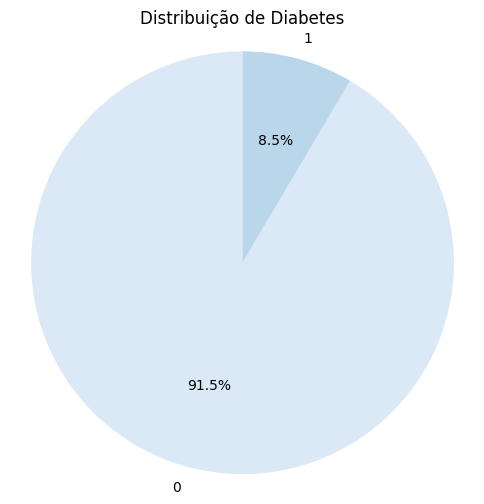

In [5]:
column ='diabetes'
column_name='gender'
df_counts = df.groupby(f'{column}').count()[column_name].sort_values(ascending=False).reset_index(name='count')[0:10]
df_counts[f'{column}'] = df_counts[f'{column}'].astype(str)

plt.figure(figsize=(6, 6))
plt.pie(df_counts['count'], labels=df_counts['diabetes'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Blues'))
plt.title('Distribuição de Diabetes')
plt.axis('equal')
plt.show()

In [6]:
df['blood_glucose_level'] = df['blood_glucose_level'].astype(float)

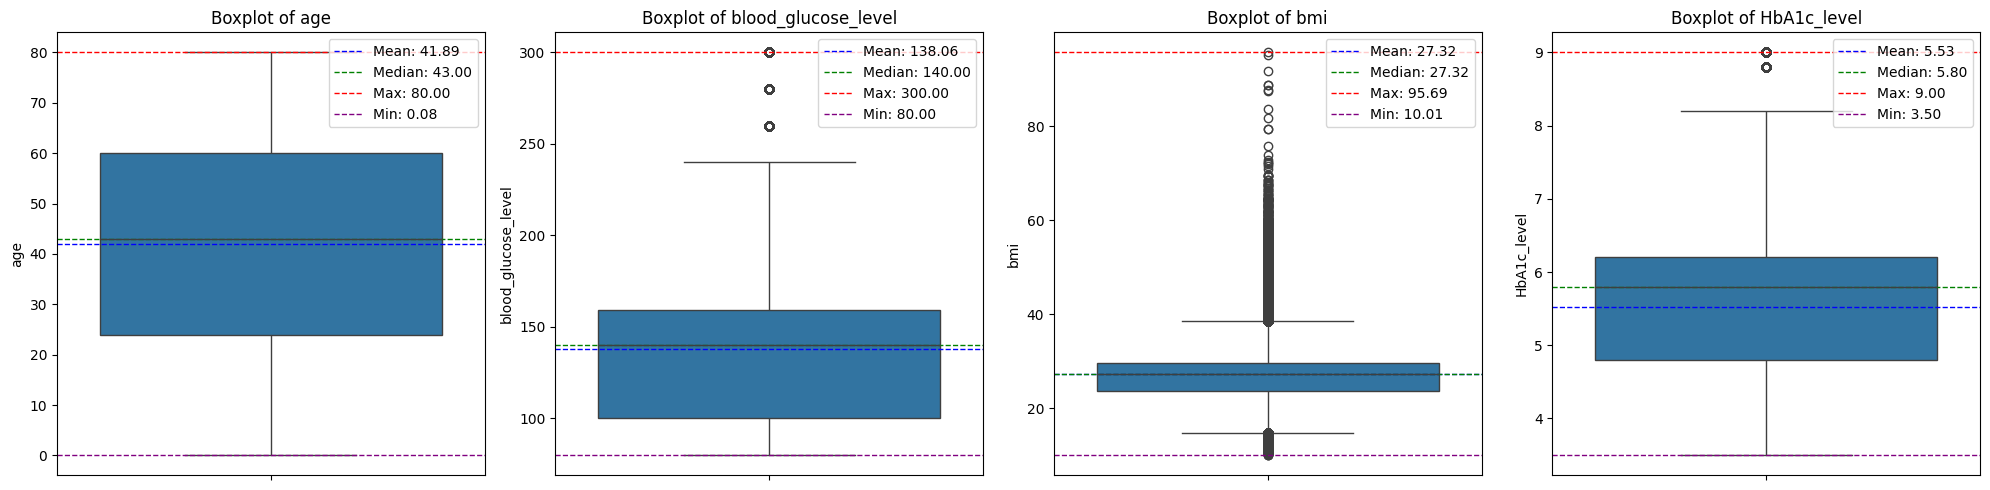

In [7]:
features_list = df.select_dtypes("float").columns.tolist()
plot_boxplots_by_columns(df,features_list)

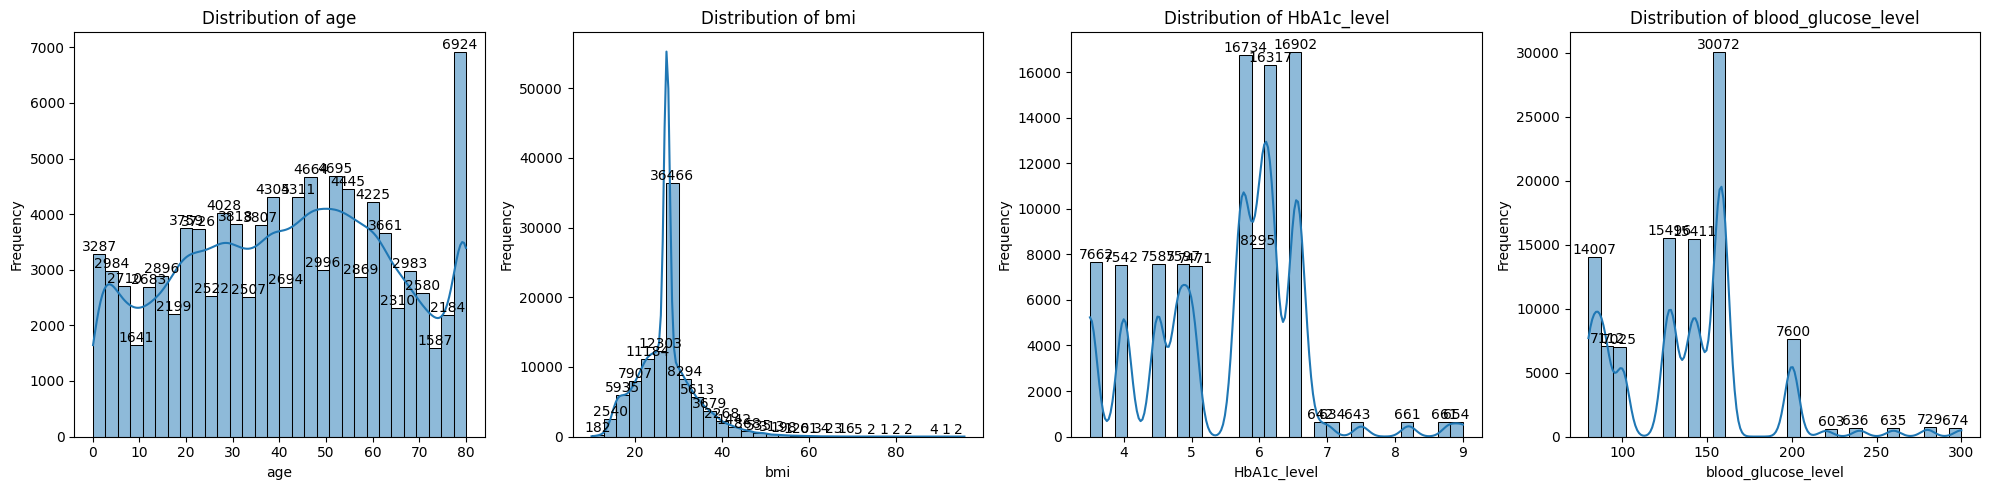

In [8]:
plot_by_columns(df,features_list)

In [9]:
string_features =  df.select_dtypes("object").columns.tolist()
string_features_bool = df.select_dtypes("int").columns.tolist()
string_features_bool.remove('diabetes')

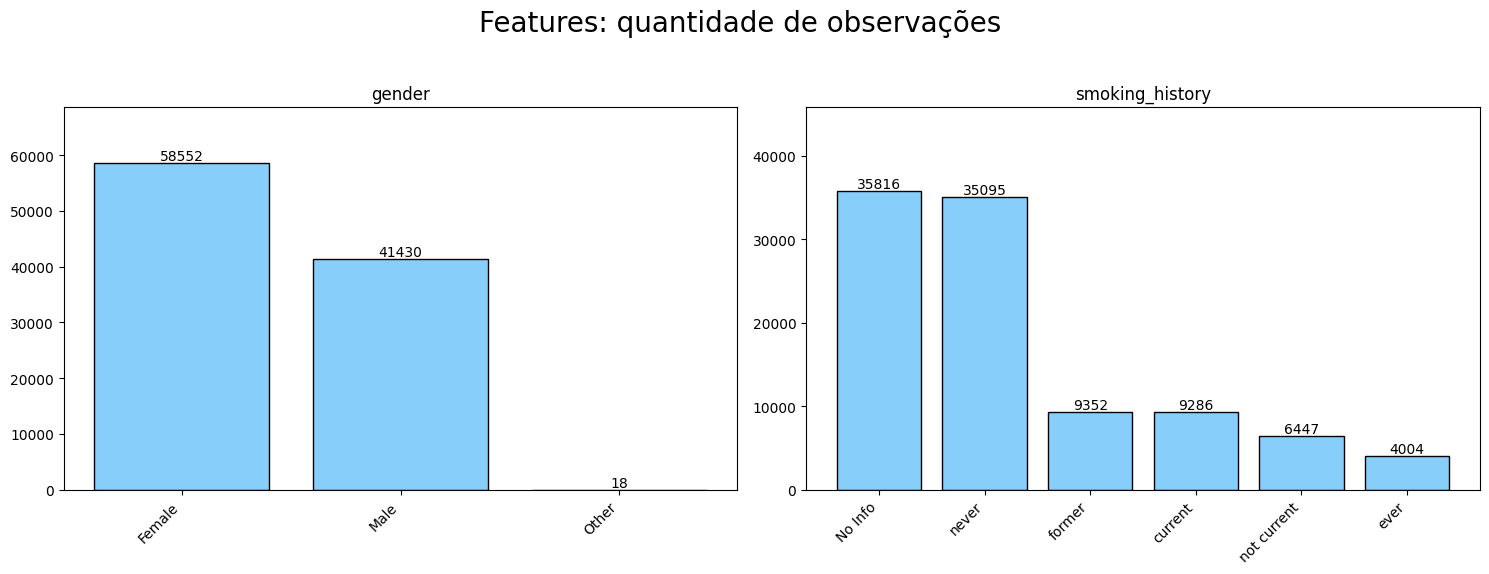

In [10]:
plot_bar_list_features(df=df, feature_list = string_features)

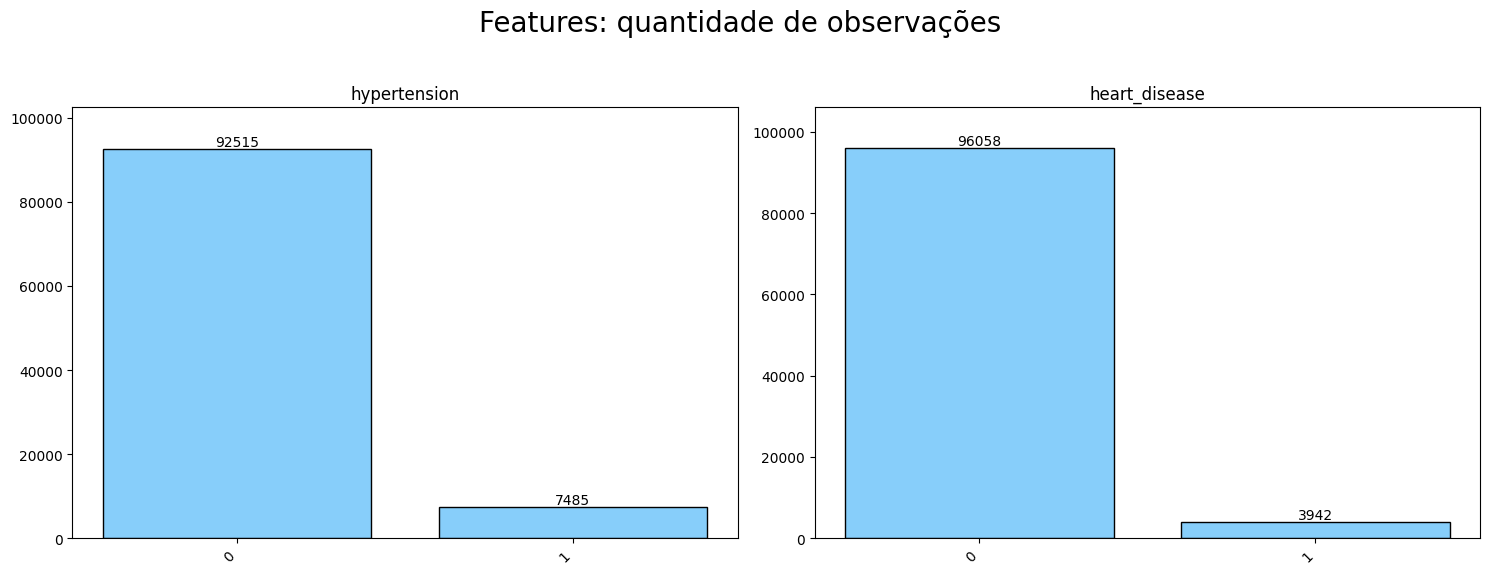

In [11]:
plot_bar_list_features(df=df, feature_list = string_features_bool)

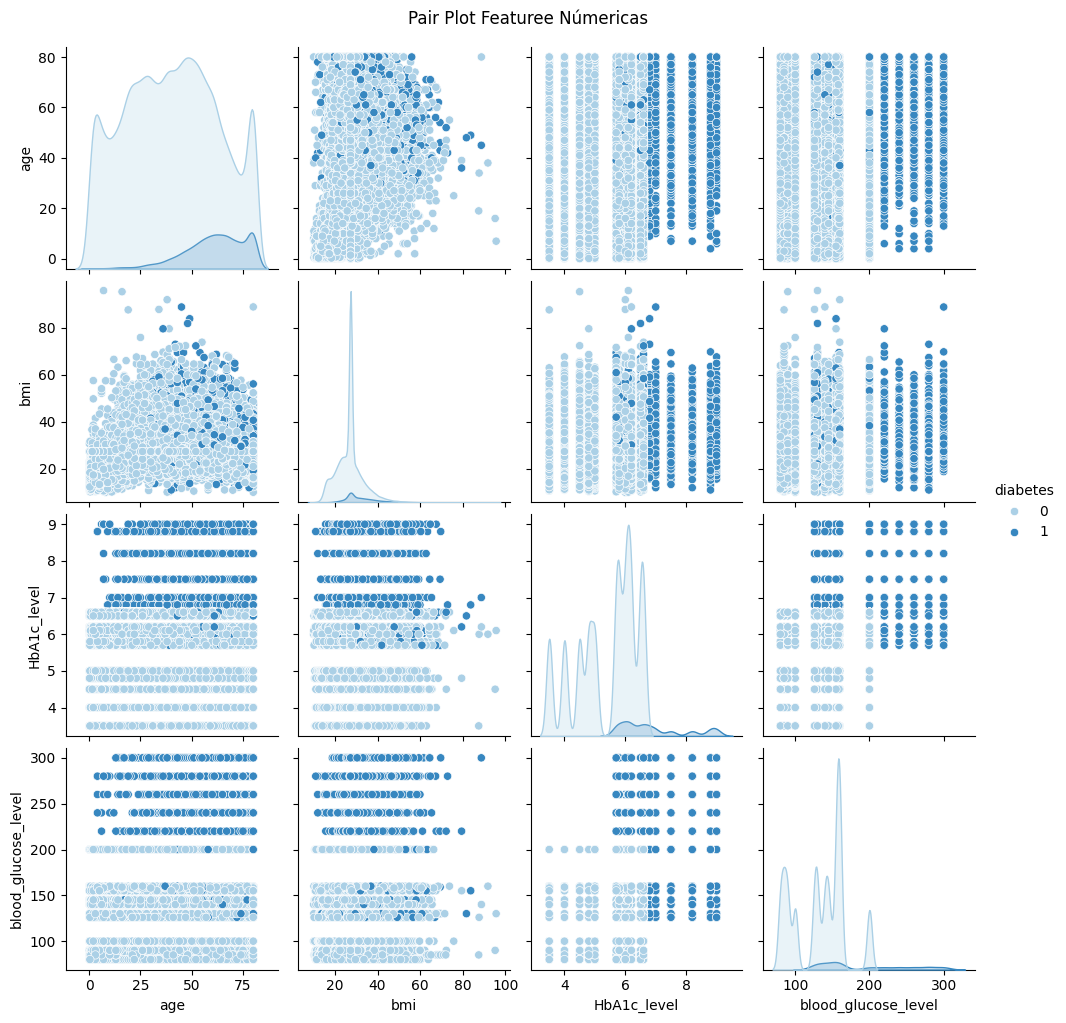

In [12]:
sns.pairplot(df[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']], hue='diabetes', palette='Blues')
plt.suptitle('Pair Plot Featuree Númericas', y=1.02) 
plt.show()

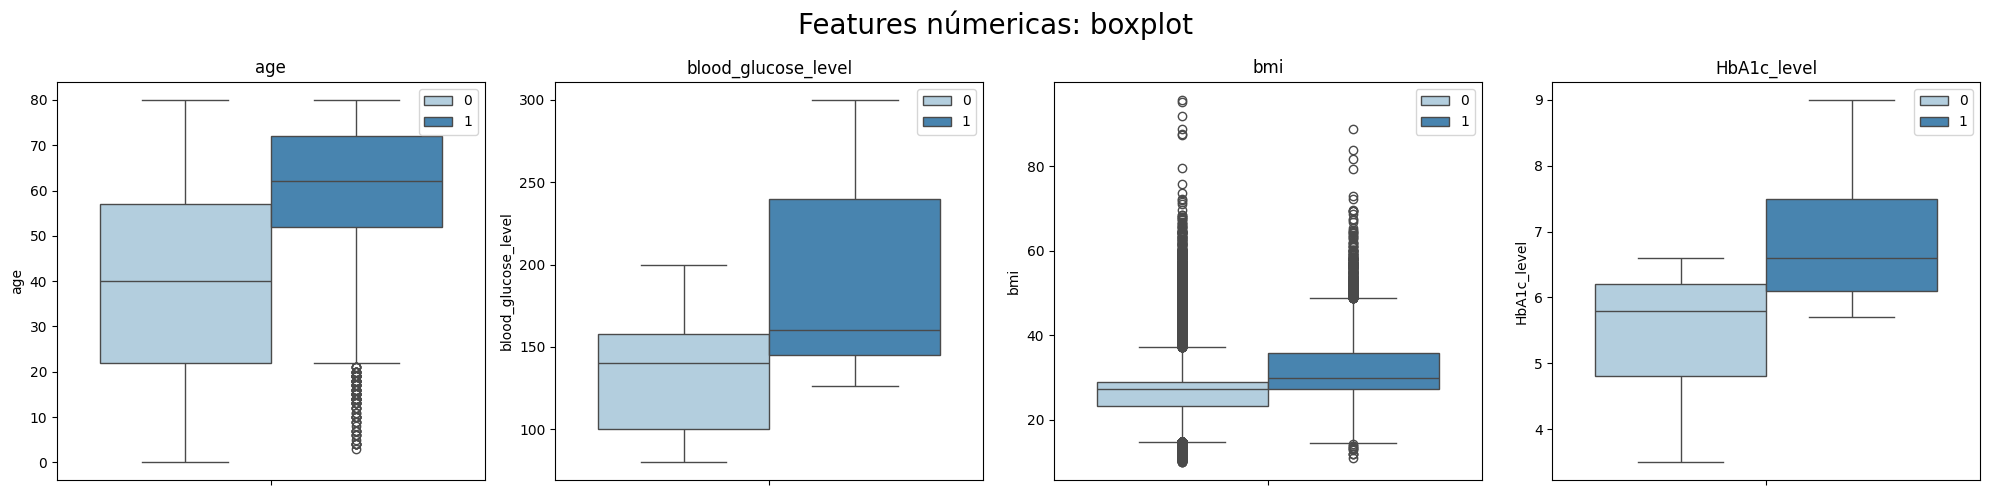

In [13]:
plot_boxplots_by_columns_hue(
    df=df, 
    column_names=['age', 'bmi', 'HbA1c_level', 'blood_glucose_level'], 
    hue='diabetes')

In [14]:
correlation_matrix = df[['age',  'bmi', 'HbA1c_level', 'blood_glucose_level','diabetes']].corr(method='pearson')

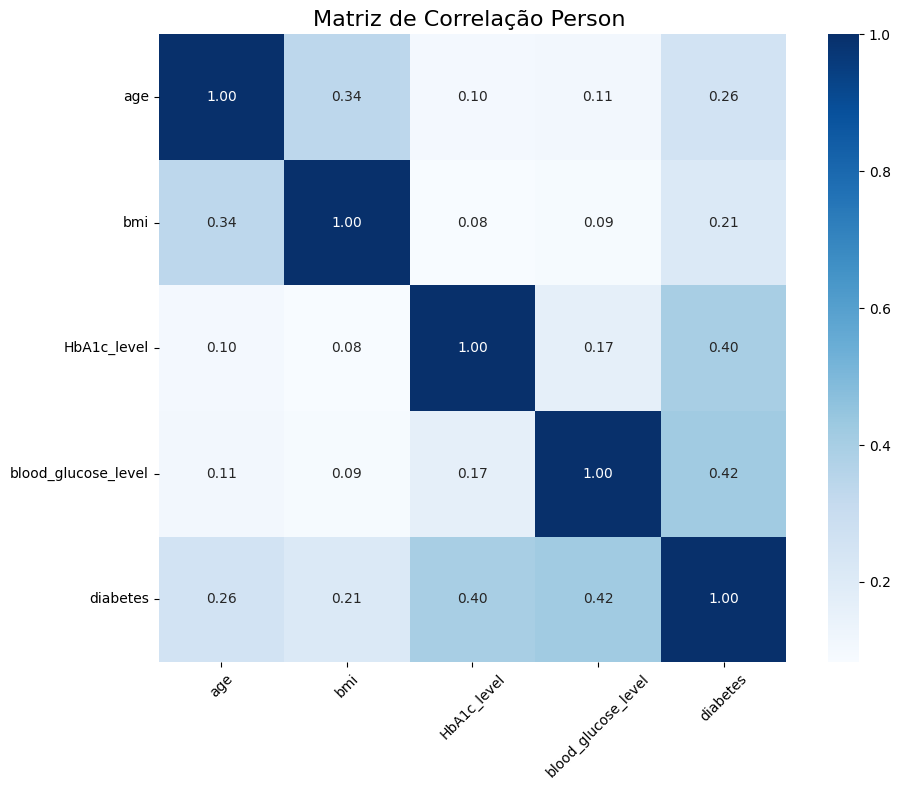

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=True, square=True)
plt.title("Matriz de Correlação Person ", fontsize=16)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

In [16]:
string_features_bool

['hypertension', 'heart_disease']

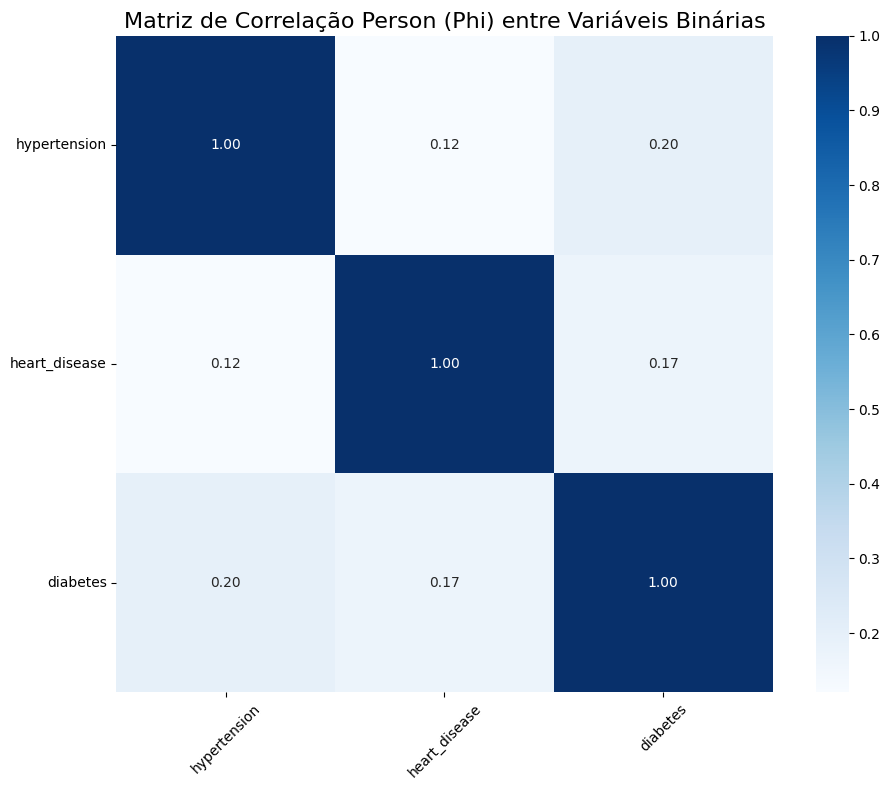

In [17]:
correlation_matrix_binary = df[['hypertension', 'heart_disease','diabetes']].corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_binary, annot=True, fmt=".2f", cmap="Blues", cbar=True, square=True)
plt.title("Matriz de Correlação Person (Phi) entre Variáveis Binárias", fontsize=16)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()


## Tranformação das features - Preprocessing

In [18]:
print('The old shape is:', df.shape)

df = df[df['gender'] != 'Other'] # Remover registros com gênero 'Other' devido à baixa representatividade

print('The new shape is:', df.shape)

The old shape is: (100000, 9)
The new shape is: (99982, 9)


In [19]:
print('The old shape is:', df.shape)

df = df.query('age > 17') # Remover registros com menores de idade

print('The new shape is:', df.shape)

The old shape is: (99982, 9)
The new shape is: (82767, 9)


In [20]:
data = pd.get_dummies(df, columns=['gender', 'smoking_history'], drop_first=True)

In [21]:
data = data.applymap(lambda x: 1 if x is True else (0 if x is False else x))

In [22]:
data.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
count,82767.000000,82767.000000,82767.000000,82767.000000,82767.000000,82767.000000,82767.000000,82767.000000,82767.000000,82767.000000,82767.000000,82767.000000,82767.000000
mean,48.858966,0.090350,0.047567,28.623865,5.550681,139.090314,0.101707,0.394735,0.110878,0.048220,0.112629,0.382930,0.071514
std,18.014490,0.286684,0.212850,6.062887,1.087550,41.792965,0.302265,0.488797,0.313982,0.214231,0.316141,0.486104,0.257683
min,18.000000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.000000,0.000000,0.000000,25.555000,4.800000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,49.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,63.000000,0.000000,0.000000,30.650000,6.200000,159.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,80.000000,1.000000,1.000000,91.820000,9.000000,300.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
data.columns = data.columns.str.strip()
data.columns = data.columns.str.replace(' ', '_')

In [24]:
data.drop_duplicates(inplace=True)

## Separando features e target
#### Dividir os dados em treino, validação e teste



In [25]:
X = data.drop('diabetes', axis=1)
y = data['diabetes']

In [26]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.25, random_state=42, stratify=y_) # 0.25 de 0.8 é 0.2


In [27]:
## Identificação de colunas numéricas (float) para escalonamento
float_columns = X_train.select_dtypes(include=['float']).columns.tolist() 
print(f"Colunas numéricas para escalonamento: {float_columns}")

Colunas numéricas para escalonamento: ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']


In [28]:
## Escalonamento das features numéricas
scaler = StandardScaler()
X_train[float_columns] = scaler.fit_transform(X_train[float_columns])
X_val[float_columns] = scaler.transform(X_val[float_columns])
X_test[float_columns] = scaler.transform(X_test[float_columns])

print("\nPré-processamento concluído.")


Pré-processamento concluído.


## balanceamento de classes

In [29]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [30]:
print("Aplicando Oversampling...")
oversampler = RandomOverSampler(random_state=42)
X_train_resampled_over, y_train_resampled_over = oversampler.fit_resample(X_train, y_train)
print(f"Shape de X_train após oversampling: {X_train_resampled_over.shape}")
print(f"Contagem de classes em y_train após oversampling:\n{y_train_resampled_over.value_counts()}")

Aplicando Oversampling...
Shape de X_train após oversampling: (85252, 12)
Contagem de classes em y_train após oversampling:
diabetes
0    42626
1    42626
Name: count, dtype: int64


# Treinamento

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten  ,BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from utils.early_stopping import CustomEarlyStopping
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt
import tensorflow as tf

In [32]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
y_val_encoded = to_categorical(y_val)
y_train_resampled_over_encoded = to_categorical(y_train_resampled_over)
num_classes = y_train_encoded.shape[1]
num_classes

2

In [33]:
# Ponderação de classes (opcional, para dados desbalanceados)
# Isso dá mais peso à classe minoritária durante o cálculo da perda,
# incentivando o modelo a classificá-la corretamente.
# Calcule os pesos com base na distribuição das classes em y_train.
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

## Rede neural 1 camada 

In [34]:
# config so we can easily change
balance_treatment_type = 'oversampling' # 'undersampling', or 'oversampling'
target_col = 'diabetes'
random_state = 42
dataset_test_size = 0.2
learning_rate = 0.001
epochs = 500
batch_size = 128
loss_function = 'binary_crossentropy' # 'focal_loss', 'binary_crossentropy', 'categorical_crossentropy', 'sparse_categorical_crossentropy', 'mse', 'mae', 'hinge'
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
n_neurons = 1
activation_function = 'relu'
optimizer_type = 'adam'  # 'adam', 'sgd', 'rmsprop'

# Early stopping configuration
early_stopping_patience = 10 # number of epochs to wait before stopping the training
min_improvement = 0.02 # should improve at least 2% in the validation loss to continue training
early_stopping_monitor = 'recall'

In [ ]:
optimizer = None
if optimizer_type == 'adam':
    optimizer = Adam(learning_rate=learning_rate)
elif optimizer_type == 'sgd':
    optimizer = SGD(learning_rate=learning_rate)
elif optimizer_type == 'rmsprop':
    optimizer = RMSprop(learning_rate=learning_rate)
else:
    raise ValueError(f"Invalid optimizer type: {optimizer_type}")

# Crie o modelo com o número de neurônios na camada de entrada
model_baseline = Sequential([
    Dense(n_neurons, activation=activation_function, input_shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid') # Saída para classificação binária
])

model_baseline.compile(
    optimizer=optimizer,
    loss=loss_function, 
    metrics=metrics 
)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [36]:
# Treine o modelo
history_baseline = model_baseline.fit(
    X_train,
    y_train ,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    class_weight=class_weight_dict, 
    validation_data=(X_val, y_val), 
    verbose=1
)

Epoch 1/500


2025-09-25 17:49:32.419892: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4309 - f1_score: 0.1934 - loss: 0.7201 - precision: 0.0262 - recall: 0.1330 - val_accuracy: 0.7452 - val_f1_score: 0.1912 - val_loss: 0.6894 - val_precision: 0.0025 - val_recall: 0.0036
Epoch 2/500
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.7701 - f1_score: 0.1934 - loss: 0.6980 - precision: 0.0036 - recall: 0.0043 - val_accuracy: 0.8943 - val_f1_score: 0.1912 - val_loss: 0.6880 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/500
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.6914 - f1_score: 0.1934 - loss: 0.6902 - precision: 0.1356 - recall: 0.4531 - val_accuracy: 0.7516 - val_f1_score: 0.1912 - val_loss: 0.5287 - val_precision: 0.2879 - val_recall: 0.9161
Epoch 4/500
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.7807 - f1_score: 0.1934 - loss: 0.5511 - precision: 0.3155 - recall: 0.8940 - val_accuracy: 0.8082 - val_f1_score: 0.1912 - val_loss: 0.3664 - val_precision: 0.3443 - val_r

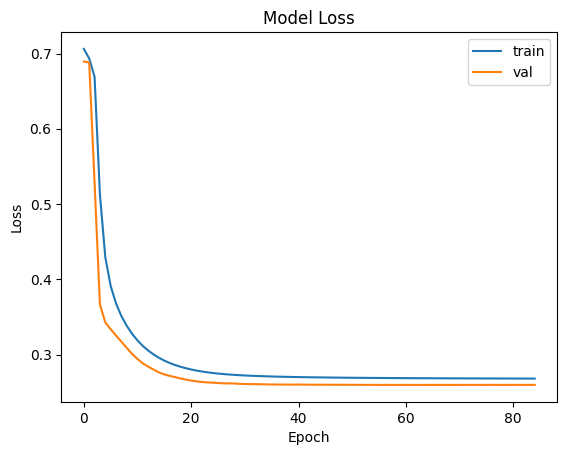

In [37]:
plt.plot(history_baseline.history['loss'], label='train')
plt.plot(history_baseline.history['val_loss'], label='val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

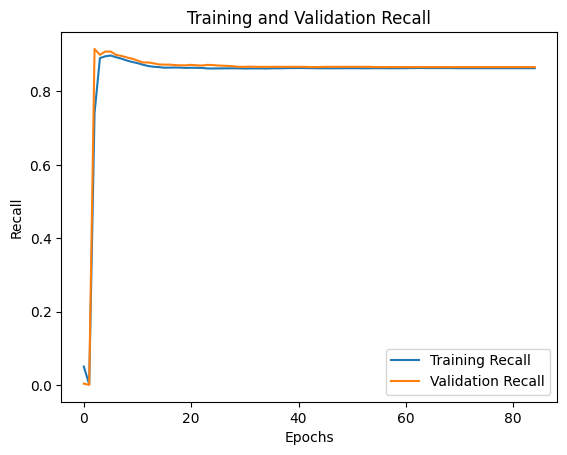

In [38]:
recall = history_baseline.history['recall']
val_recall = history_baseline.history['val_recall']
 
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [39]:
y_pred_test = model_baseline.predict(X_test)
y_pred_labels = (y_pred_test > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred_labels))

497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


2025-09-25 17:49:56.945125: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


              precision    recall  f1-score   support

           0       0.98      0.88      0.93     14209
           1       0.45      0.86      0.59      1680

    accuracy                           0.88     15889
   macro avg       0.72      0.87      0.76     15889
weighted avg       0.93      0.88      0.89     15889



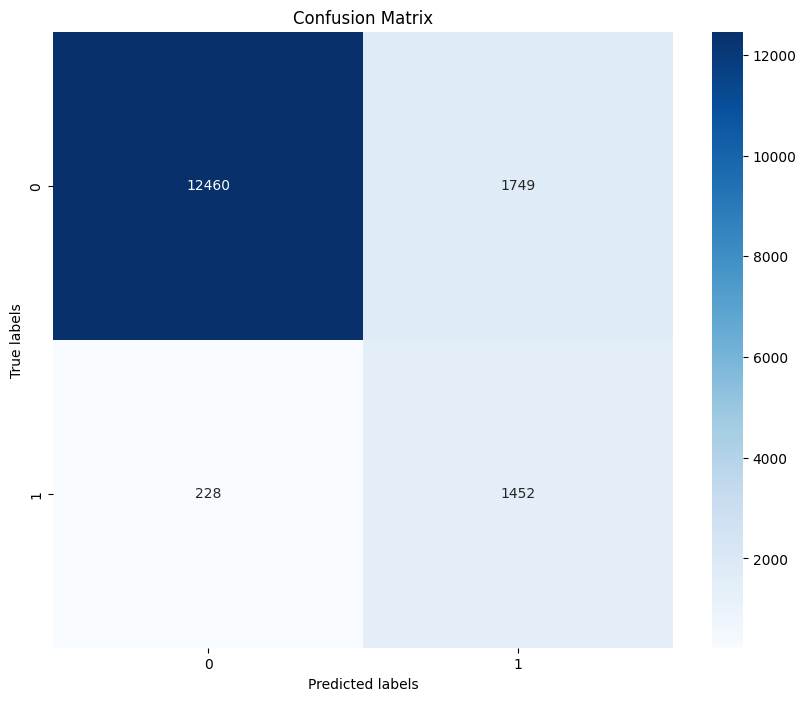

In [40]:
cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [41]:
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_test.flatten())

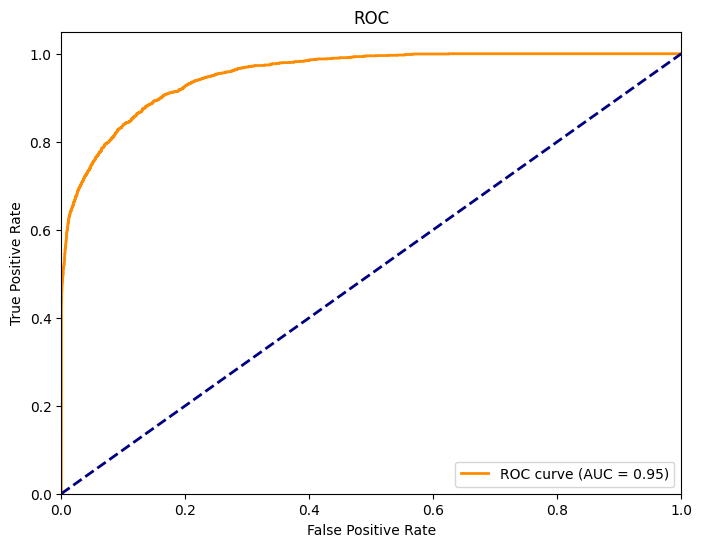

In [42]:
# plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

## modelo profundo com mais camadas

In [119]:
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
optimizer = SGD(learning_rate=0.001)
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dense(16,  activation='relu'))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  


model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=25)

In [120]:
# Train model
history = model.fit(
    X_train, 
    y_train, 
    epochs=5000, 
    batch_size=128, 
    verbose=1,
    class_weight=class_weight_dict, 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping,rlr]
)

Epoch 1/5000


2025-09-25 19:21:15.166416: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4226 - f1_score: 0.1934 - loss: 0.8558 - precision: 0.0381 - recall: 0.1808 - val_accuracy: 0.4952 - val_f1_score: 0.1912 - val_loss: 0.7120 - val_precision: 0.0774 - val_recall: 0.3458 - learning_rate: 0.0010
Epoch 2/5000
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.5670 - f1_score: 0.1934 - loss: 0.6882 - precision: 0.1179 - recall: 0.4695 - val_accuracy: 0.6465 - val_f1_score: 0.1912 - val_loss: 0.6058 - val_precision: 0.1918 - val_recall: 0.7292 - learning_rate: 0.0010
Epoch 3/5000
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.6643 - f1_score: 0.1934 - loss: 0.5653 - precision: 0.2091 - recall: 0.7670 - val_accuracy: 0.7148 - val_f1_score: 0.1912 - val_loss: 0.5547 - val_precision: 0.2472 - val_recall: 0.8298 - learning_rate: 0.0010
Epoch 4/5000
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.7235 - f1_score: 0.1934 - loss: 0.4913 - precision: 0.2576 - recall: 0.8402 - val_accuracy: 0.7531 - val_

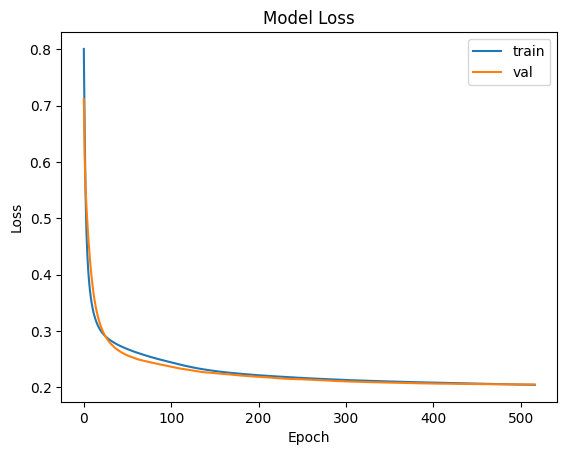

In [121]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

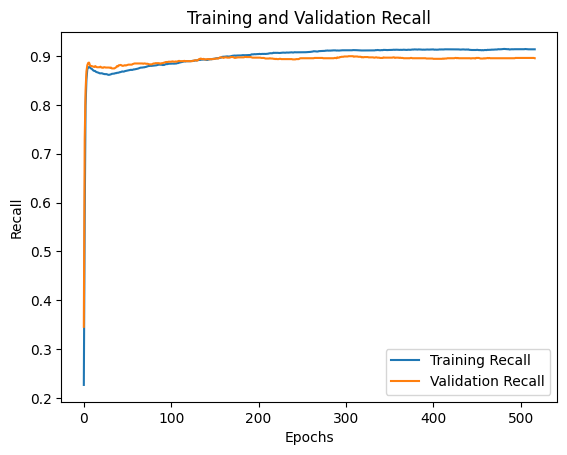

In [122]:
recall = history.history['recall']
val_recall = history.history['val_recall']

plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [123]:
y_pred_test = model.predict(X_test)
y_pred_labels = (y_pred_test > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred_labels))

367/497 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step

2025-09-25 19:24:15.496961: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step
              precision    recall  f1-score   support

           0       0.99      0.89      0.93     14209
           1       0.48      0.89      0.62      1680

    accuracy                           0.89     15889
   macro avg       0.73      0.89      0.78     15889
weighted avg       0.93      0.89      0.90     15889



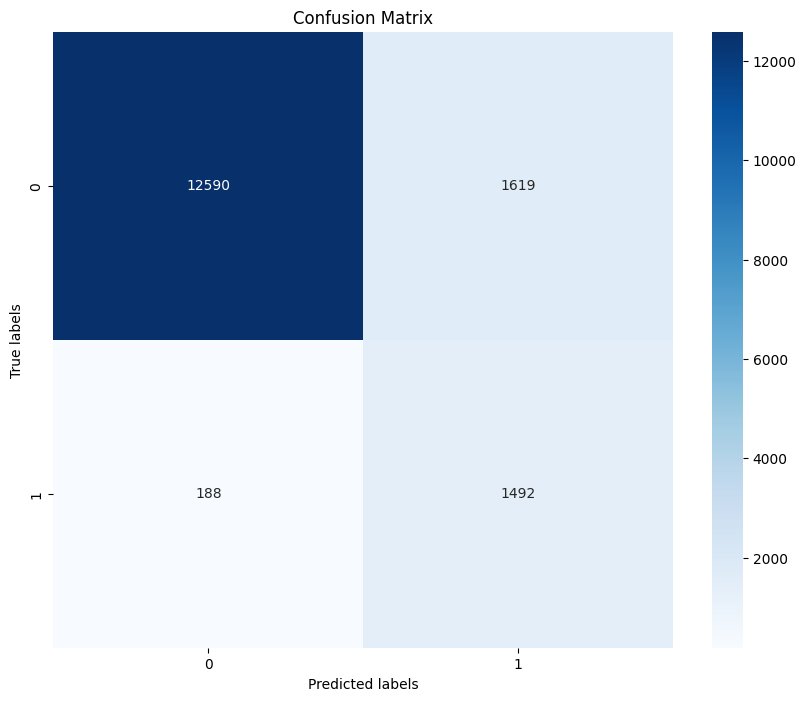

In [124]:
cm = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [125]:
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_test.flatten())

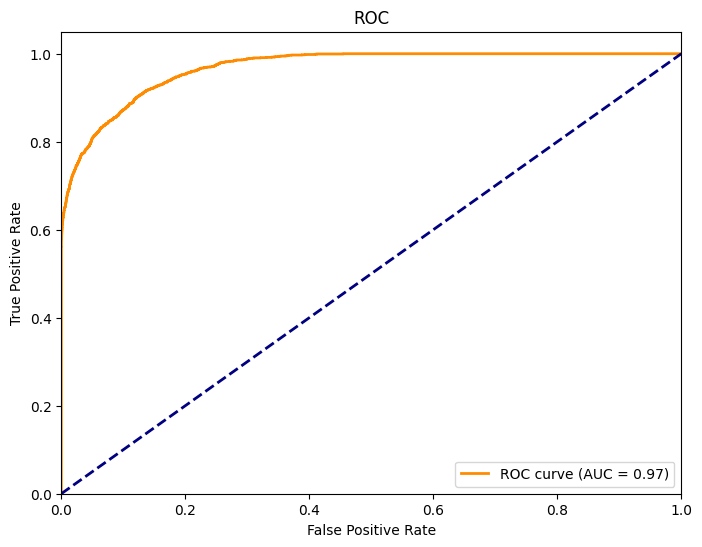

In [126]:
# plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [127]:
from tensorflow.keras.models import load_model

# Salvar modelo Keras
model_baseline.save('model_baseline.h5')

# Carregar modelo Keras
loaded_baseline_model = load_model('model_baseline.h5')

# Fazer predição
y_pred_baseline_loaded = loaded_baseline_model.predict(X_test)

425/497 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step

2025-09-25 19:24:25.222187: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


In [128]:

y_pred_labels_baseline_loaded = (y_pred_baseline_loaded > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred_labels_baseline_loaded))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93     14209
           1       0.45      0.86      0.59      1680

    accuracy                           0.88     15889
   macro avg       0.72      0.87      0.76     15889
weighted avg       0.93      0.88      0.89     15889



In [129]:
# Salvar modelo Keras
model.save('model.h5')

# Carregar modelo Keras
loaded_model = load_model('model.h5')

# Fazer predição
y_pred_loaded = loaded_model.predict(X_test)

156/497 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step

2025-09-25 19:24:30.518184: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step


In [130]:
y_pred_labels_loaded = (y_pred_loaded > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred_labels_loaded)) 

              precision    recall  f1-score   support

           0       0.99      0.89      0.93     14209
           1       0.48      0.89      0.62      1680

    accuracy                           0.89     15889
   macro avg       0.73      0.89      0.78     15889
weighted avg       0.93      0.89      0.90     15889



# Outros testes

In [ ]:
from sklearn.decomposition import PCA

# Reduzindo a dimensionalidade para 2 componentes principais para visualização ou para 8 para modelagem
n_components = 4
pca = PCA(n_components=n_components, random_state=42)

# Ajusta o PCA apenas nos dados de treino e transforma todos os conjuntos
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

print(f"Variância explicada pelos {n_components} componentes: {np.sum(pca.explained_variance_ratio_):.2%}")

In [ ]:
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
optimizer = Adam(learning_rate=0.001)
 
# model_pca = Sequential()
# model_pca.add(Dense(32, input_dim=X_train_pca.shape[1], activation='relu'))
# model_pca.add(BatchNormalization())
# model_pca.add(Dropout(0.10))
# model_pca.add(Dense(16, activation='relu'))
# model_pca.add(Dense(1, activation='sigmoid'))  # Saída para classificação binária

model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  

model_pca.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [ ]:
# Train model
history_pca = model_pca.fit(
    X_train_pca, 
    y_train, 
    epochs=5000, 
    batch_size=batch_size, 
    verbose=1,
    class_weight=class_weight_dict, 
    validation_data=(X_val_pca, y_val), 
    callbacks=[early_stopping]
)

In [ ]:
plt.plot(history_pca.history['loss'], label='train')
plt.plot(history_pca.history['val_loss'], label='val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
recall = history_pca.history['recall']
val_recall = history_pca.history['val_recall']

plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [ ]:
y_pred_test = model_pca.predict(X_test_pca)
y_pred_labels = (y_pred_test > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred_labels))



# Modelo profundo oversampling

In [ ]:
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
optimizer = Adam(learning_rate=0.001)
#Compile model
model_resamp = Sequential()
model_resamp.add(Dense(64, input_dim=X_train_resampled_over.shape[1], activation='relu'))
model_resamp.add(Dense(32, activation='relu'))
model_resamp.add(Dense(16, activation='relu'))

model_resamp.add(Dense(num_classes, activation='softmax'))
model_resamp.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [ ]:
# Train model
history_resampl = model_resamp.fit(
    X_train_resampled_over, 
    y_train_resampled_over_encoded, 
    epochs=2000, 
    batch_size=batch_size, 
    verbose=1,
    # class_weight=class_weight_dict, 
    validation_data=(X_val, y_val_encoded), 
    callbacks=[early_stopping],
    random_state = 42
)

In [ ]:
plt.plot(history_resampl.history['loss'], label='train')
plt.plot(history_resampl.history['val_loss'], label='val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
recall = history_resampl.history['recall']
val_recall = history_resampl.history['val_recall']

plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [ ]:
y_pred_test = model_resamp.predict(X_test)
y_pred_t = np.argmax(y_pred_test, axis=1)
y_test_non_categorical = np.argmax(y_test_encoded, axis=1)
print(classification_report(y_test_non_categorical, y_pred_t))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras import regularizers

In [ ]:
def build_model(hp):
    """
    This function will find the best HyperParameters for this Artificial Neural Network.
    """
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    
    num_hidden_layers = hp.Int('num_hidden_layers', min_value=1, max_value=4, step=1)
    prev_units = None 

    for i in range(num_hidden_layers):
        max_units = max(prev_units - 16, 16) if prev_units else 128
        min_units = 16

        units = hp.Int(f'num_units_layer_{i+1}', min_value=min_units, max_value=max_units, step=16)

        model.add(Dense(units, 
                        activation='relu', 
                        kernel_regularizer=tf.keras.regularizers.l2(1e-4)))  #  Regularização L2
        model.add(BatchNormalization())  # Normalização em cada camada

        use_dropout = hp.Boolean(f'use_dropout_layer_{i+1}')
        if use_dropout:
            dropout_rate = hp.Float(f'dropout_rate_layer_{i+1}', min_value=0.2, max_value=0.5, sampling='linear')
            model.add(Dropout(dropout_rate))

        prev_units = units

    # Saída adaptada para problema binário (ajuste se seu y for one-hot ou não)
    model.add(Dense(1, activation='sigmoid'))  # Saída para classificação binária

    model.compile(
        optimizer=SGD(learning_rate=hp.Float('learning_rate',
                                              min_value=1e-5,
                                              max_value=1e-2,
                                              sampling='log')),
        loss='binary_crossentropy',
        metrics=metrics
    )

    return model

class MyTuner(kt.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size',
                                                         min_value=32,
                                                         max_value=128,
                                                         step=8)
        return super(MyTuner, self).run_trial(trial, *args, **kwargs)


tuner = MyTuner(
    build_model,              
    objective='val_loss',   
    max_trials=10,             # mais testes = maior chance de achar config boa
    executions_per_trial=1,    
    directory='tuner_results', 
    project_name='diabetes',   
    overwrite=True,
    seed=42
)

# EarlyStopping + ReduceLROnPlateau
es_1 = EarlyStopping(patience=15, monitor='val_loss', mode='min', restore_best_weights=True)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=15)

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=2000,
    callbacks=[es_1, rlr],
    class_weight=class_weight_dict,
    verbose=1
)


In [ ]:
all_trials = tuner.oracle.trials.values()

results = []
for trial in all_trials:
    trial_data = trial.hyperparameters.values
    trial_data['score'] = trial.score
    results.append(trial_data)

trials_df = pd.DataFrame(results)

In [ ]:
trials_df

In [ ]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

all_hyperparameters = best_hps.values

#print all hyperparameters
for key, value in all_hyperparameters.items():
    print(f"{key}: {value}")

In [ ]:
def best_model():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    # Layer 1
    model.add(Dense(80, activation='tanh'))
    model.add(BatchNormalization())  
    model.add(Dropout(0.22133225224489173))
    # Layer 2
    model.add(Dense(16, activation='tanh'))
    model.add(BatchNormalization())  
    model.add(Dropout(0.4471421725892264))
    # Layer 3
    model.add(Dense(16, activation='tanh'))
    model.add(BatchNormalization())  
    model.add(Dropout(0.4119721205747523))
    # Layer 4
    model.add(Dense(16, activation='tanh'))
    model.add(BatchNormalization())  
    model.add(Dropout(0.26094269191265823))
    # Output
    model.add(Dense(1, activation='sigmoid'))  # Saída para classificação binária
    model.compile(
        optimizer=Adam(learning_rate=0.005237372527286113),
        loss='binary_crossentropy',
        metrics=metrics
    )
    return model

es_2 = EarlyStopping(
    patience=5,
    monitor='val_loss',
    mode='min',
    restore_best_weights=True
)

rlr_2 = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=15)
es_2 = EarlyStopping(patience=15, monitor='val_loss', mode='min', restore_best_weights=True)
best_model = best_model()

#histo: is a history variable to store the graphs
histo = best_model.fit(
    X_train, y_train, 
    batch_size=72,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    epochs=2000, callbacks=[es_2,rlr_2], verbose=1 )

In [ ]:
plt.plot(histo.history['loss'], label='Training Loss' )
plt.plot(histo.history['val_loss'], label='Validation Loss' )

#making the graph presentable
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
recall = histo.history['recall']
val_recall = histo.history['val_recall']

plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [ ]:
y_pred_test = best_model.predict(X_test)
y_pred_labels = (y_pred_test > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred_labels))